In [1]:
import qiskit
import qiskit_ibm_runtime as runtime
import qiskit_aer
import numpy as np


In [2]:
import pickle
with open("circuits.bin","rb") as f:
    circuits = pickle.load(f)

## Draw some circuits, just to make sure they look ok

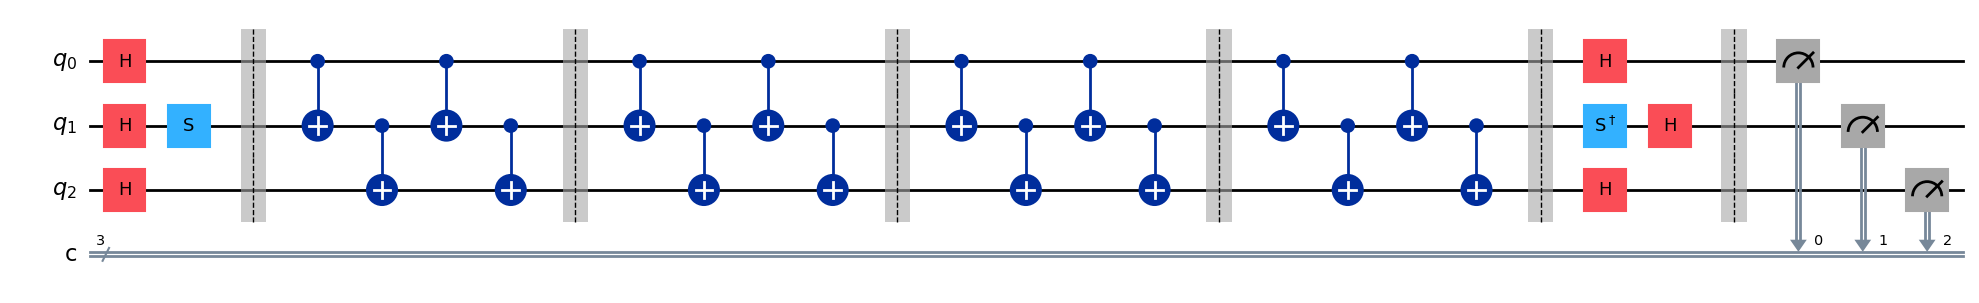

In [3]:
circuits[1][1].draw(output="mpl",fold=-1,idle_wires=False)

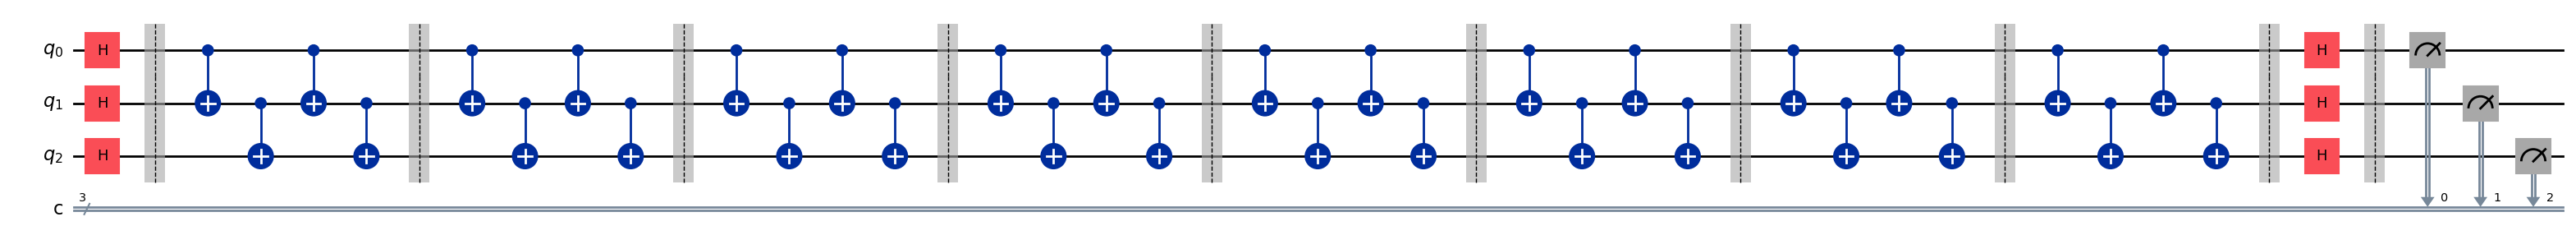

In [4]:
circuits[0][2].draw(output="mpl",fold=-1,idle_wires=False)

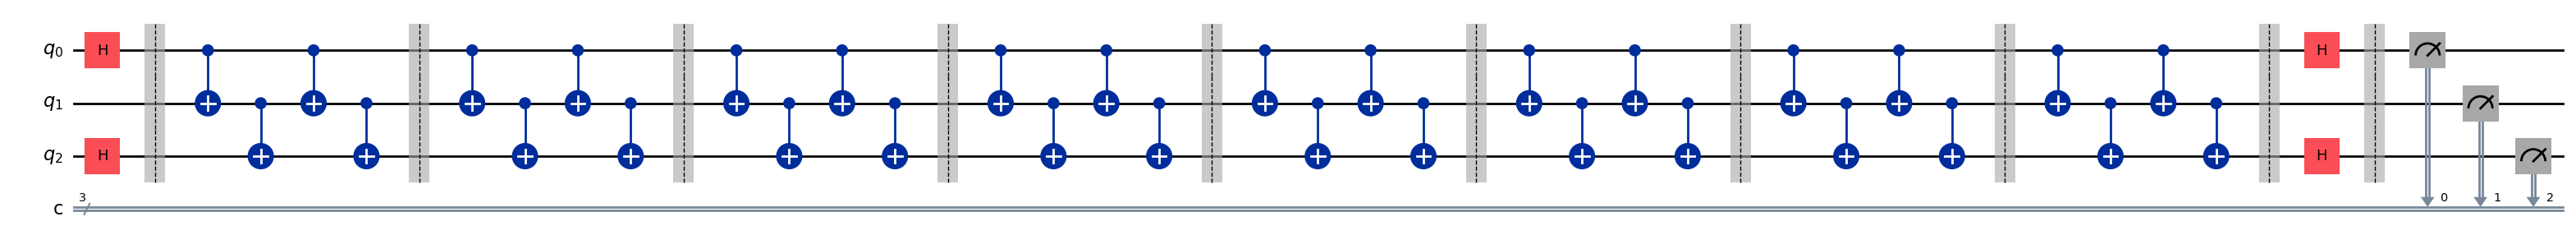

In [5]:
circuits[2][2].draw(output="mpl",fold=-1,idle_wires=False)

## Sanity check that they all return 1 result and its '000'

In [6]:
from qiskit_aer import AerSimulator
simulator = AerSimulator(method="stabilizer")
for x in circuits:
    for c in x:
        aj = simulator.run(c)
        ajr = aj.result().get_counts()
        assert len(ajr.keys()) == 1, "More than one result?"
        assert list(ajr.keys())[0] == '000', "Non zero result"
print("GTG")

GTG


## Load up runtime and transpiler, get backends

In [7]:
transpiler = qiskit.transpiler
library = qiskit.circuit.library
visualization = qiskit.visualization
XGate = library.XGate

service = runtime.QiskitRuntimeService()
bk = service.backends(simulator=False,operational=True,min_num_qubits=7)


/var/folders/sx/_sk432ts16j1x98vgrt62wfc0000gp/T/ipykernel_82480/2597834491.py:6: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = runtime.QiskitRuntimeService()


In [8]:
backend = bk[0]
backend

<IBMBackend('ibm_aachen')>

In [9]:
transpiled_circuits = []
for x in circuits:
    for c in x:
        qr = c.qregs[0] # Grab the quantum register.
        layout = qiskit.transpiler.Layout(input_dict={qr[0]:6,qr[1]:7,qr[2]:17}) # This is how we will map the qubits onto the device
        pm = transpiler.generate_preset_pass_manager(3, target=backend.target, seed_transpiler=12345,initial_layout=layout,layout_method="trivial")
        c_transpiled = pm.run(c)
        transpiled_circuits.append(c_transpiled)

## Draw a few, so you can see what the transpiler did

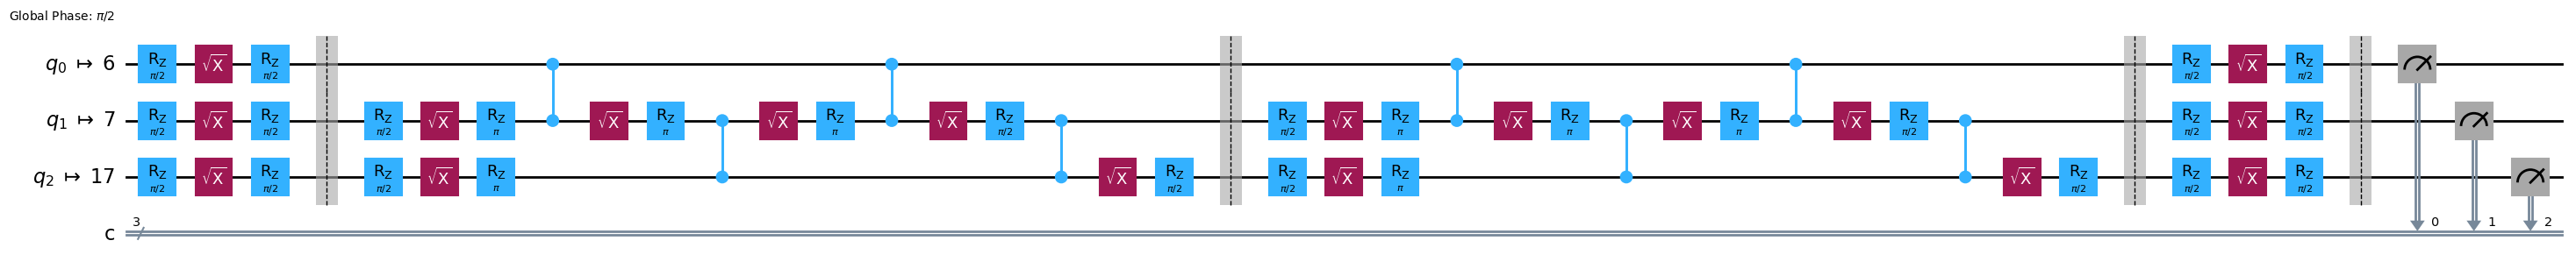

In [10]:
# Note the qubit assignment and the change to CZ gates.
transpiled_circuits[0].draw(output="mpl",fold=-1,idle_wires=False)

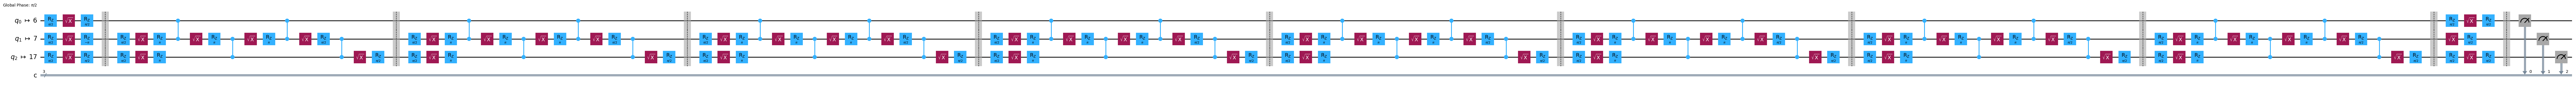

In [11]:
transpiled_circuits[56].draw(output="mpl",fold=-1,idle_wires=False)

In [12]:
len(transpiled_circuits)/6

27.0

In [18]:
#Ill save them in case you want to look at them
with open("Transpiled_circuits.pickle","wb") as f:
    pickle.dump(transpiled_circuits,f)

## Set the sampler options

In [13]:
options = runtime.SamplerOptions(experimental={"execution_path": "gen3-turbo"},
                        twirling={"enable_gates": True,"enable_measure": True,"shots_per_randomization": 128,"strategy":"active"})


In [14]:
options

max_execution_time,Unset
default_shots,Unset
experimental,{'execution_path': 'gen3-turbo'}
▸environment,EnvironmentOptions
log_level,'WARNING'
callback,None
job_tags,None
private,False
▸simulator,SimulatorOptions
noise_model,Unset
seed_simulator,Unset


In [23]:
import time
import os
def runPUBS(sampler,pubs,testOnly=False,shots=4096):
    os.makedirs("jobIds",exist_ok=True)
    jobFile = "jobIds.txt"
    if not testOnly:
        job = sampler.run(pubs,shots=shots)
        ts = time.time()
        with open("jobIds/JobIds.txt","a") as f:
            f.write(f"{ts}\t {job.job_id()}\n")
        print(f"Scheduled job ID: {job.job_id()}")
    else:
        ts = time.time()
        print(f"Would schedule job {ts} - size: {len(pubs)} runs: {shots}")


In [16]:
# Quick check for errors.
for i in range(0,len(transpiled_circuits),6):
    runPUBS(None,transpiled_circuits[i:i+6],testOnly=True)

Would schedule job 1747204281.853305 - size: 6 runs: 4096
Would schedule job 1747204281.8533819 - size: 6 runs: 4096
Would schedule job 1747204281.85345 - size: 6 runs: 4096
Would schedule job 1747204281.853477 - size: 6 runs: 4096
Would schedule job 1747204281.853531 - size: 6 runs: 4096
Would schedule job 1747204281.853549 - size: 6 runs: 4096
Would schedule job 1747204281.853562 - size: 6 runs: 4096
Would schedule job 1747204281.853576 - size: 6 runs: 4096
Would schedule job 1747204281.853589 - size: 6 runs: 4096
Would schedule job 1747204281.853653 - size: 6 runs: 4096
Would schedule job 1747204281.853725 - size: 6 runs: 4096
Would schedule job 1747204281.853747 - size: 6 runs: 4096
Would schedule job 1747204281.853764 - size: 6 runs: 4096
Would schedule job 1747204281.85378 - size: 6 runs: 4096
Would schedule job 1747204281.853793 - size: 6 runs: 4096
Would schedule job 1747204281.853853 - size: 6 runs: 4096
Would schedule job 1747204281.8539221 - size: 6 runs: 4096
Would schedule

## Run on the device

In [20]:
Session = runtime.Session
Sampler = runtime.SamplerV2
Batch = runtime.Batch

In [21]:
batch = Batch(backend=backend)
sampler = Sampler(mode=batch,options=options)

In [24]:
for i in range(0,len(transpiled_circuits),6):
    runPUBS(sampler,transpiled_circuits[i:i+6],testOnly=False)

Scheduled job ID: d0j3kbxcrrag008n3wfg
Scheduled job ID: d0j3kdd36cs0008rq5m0
Scheduled job ID: d0j3kedfbx30008wfaf0
Scheduled job ID: d0j3kf5fbx30008wfafg
Scheduled job ID: d0j3kfx36cs0008rq5mg
Scheduled job ID: d0j3kgpvpqf00080r130
Scheduled job ID: d0j3khefbx30008wfah0
Scheduled job ID: d0j3kj6vpqf00080r140
Scheduled job ID: d0j3kjy36cs0008rq5pg
Scheduled job ID: d0j3kkyfbx30008wfaj0
Scheduled job ID: d0j3kmpehmr0008gnq20
Scheduled job ID: d0j3knp8jzxg008mwnzg
Scheduled job ID: d0j3kp6vpqf00080r14g
Scheduled job ID: d0j3kq68jzxg008mwp00
Scheduled job ID: d0j3kqy36cs0008rq5q0
Scheduled job ID: d0j3krqcrrag008n3whg
Scheduled job ID: d0j3ksffbx30008wfan0
Scheduled job ID: d0j3kt7crrag008n3wj0
Scheduled job ID: d0j3ktzehmr0008gnq4g
Scheduled job ID: d0j3kvq36cs0008rq5r0
Scheduled job ID: d0j3kw736cs0008rq5s0
Scheduled job ID: d0j3kwzvpqf00080r16g
Scheduled job ID: d0j3kxqcrrag008n3wkg
Scheduled job ID: d0j3kyffbx30008wfaq0
Scheduled job ID: d0j3kyzehmr0008gnq5g
Scheduled job ID: d0j3kzq

In [ ]:
batch.close()

In [30]:
import csv
successful_job_count = 0
os.makedirs("results",exist_ok=True)
with open("jobIds/jobIds.txt","r") as f:
    reader = csv.reader(f,delimiter=' ')
    for row in reader:
        j = service.job(row[1])
        present_state = j.status()
        if j.status() == "DONE":
            results = j.result()
            dataresults = [x.data.c for x in results]
            print(f"Found result for {row[1]}, {len(dataresults)} circuits, saving as {successful_job_count} run")
            with open(f"results/count_{successful_job_count}.pickle","wb") as f:
                pickle.dump(dataresults,f)
            successful_job_count +=1
        else:
            print(f"Job {row[1]} returned states of {present_state}")

Found result for d0j3k4cehmr0008gnpxg, 6 circuits, saving as 0 run
Found result for d0j3kbxcrrag008n3wfg, 6 circuits, saving as 1 run
Found result for d0j3kdd36cs0008rq5m0, 6 circuits, saving as 2 run
Found result for d0j3kedfbx30008wfaf0, 6 circuits, saving as 3 run
Found result for d0j3kf5fbx30008wfafg, 6 circuits, saving as 4 run
Found result for d0j3kfx36cs0008rq5mg, 6 circuits, saving as 5 run
Found result for d0j3kgpvpqf00080r130, 6 circuits, saving as 6 run
Found result for d0j3khefbx30008wfah0, 6 circuits, saving as 7 run
Found result for d0j3kj6vpqf00080r140, 6 circuits, saving as 8 run
Found result for d0j3kjy36cs0008rq5pg, 6 circuits, saving as 9 run
Found result for d0j3kkyfbx30008wfaj0, 6 circuits, saving as 10 run
Found result for d0j3kmpehmr0008gnq20, 6 circuits, saving as 11 run
Found result for d0j3knp8jzxg008mwnzg, 6 circuits, saving as 12 run
Found result for d0j3kp6vpqf00080r14g, 6 circuits, saving as 13 run
Found result for d0j3kq68jzxg008mwp00, 6 circuits, saving 

# Look at the data

In [41]:
with open("results/count_0.pickle","rb") as f:
    res0 = pickle.load(f)

In [42]:
# The first sixcircuits are in res0
res0

[BitArray(<shape=(), num_shots=4096, num_bits=3>),
 BitArray(<shape=(), num_shots=4096, num_bits=3>),
 BitArray(<shape=(), num_shots=4096, num_bits=3>),
 BitArray(<shape=(), num_shots=4096, num_bits=3>),
 BitArray(<shape=(), num_shots=4096, num_bits=3>),
 BitArray(<shape=(), num_shots=4096, num_bits=3>)]

In [43]:
# The 4096 bit_strings can be accessed as follows:
res0[0].get_bitstrings()

['000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '010',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '001',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '011',
 '000',
 '000',
 '000',
 '000',
 '010',
 '000',
 '000',
 '000',
 '011',
 '000',
 '000',
 '000',
 '010',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '011',
 '000',
 '000',
 '000',
 '010',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '100',
 '000',
 '000',
 '000',
 '000',
 '000',
 '110',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '001',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',
 '000',


In [44]:
# OR qiskit makes it easy for you.
res0[0].get_counts()

{'000': 3840,
 '010': 135,
 '001': 57,
 '011': 32,
 '100': 20,
 '110': 5,
 '101': 6,
 '111': 1}

In [40]:
# I'll leave it to you to combine this all together.